# Inceptionv3 with Data Augmentation

In [1]:

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import backend as K


from keras.preprocessing import image

import numpy as np
import os , shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #for importing and managing datasets


from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten  #Use to convert Pooled image into input later for fully connected layer
from keras.optimizers import Adam
from keras.metrics import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import confusion_matrix
#%matplotlib.inline


import itertools



from sklearn.metrics import confusion_matrix

import tensorflow as tf

/home/usojourn/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_path = '/home/usojourn/Desktop/stanford_cs230/Project/parcels/training_set'
valid_path = '/home/usojourn/Desktop/stanford_cs230/Project/parcels/validation_set'
test_path = '/home/usojourn/Desktop/stanford_cs230/Project/parcels/test_set'

In [3]:
train_batches = ImageDataGenerator().flow_from_directory(train_path,target_size=(150,150),classes = ['damaged','undamaged'],batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path,target_size=(150,150),classes = ['damaged','undamaged'],batch_size=200)
test_batches = ImageDataGenerator().flow_from_directory(test_path,target_size=(150,150),classes = ['damaged','undamaged'],batch_size=200)

Found 1929 images belonging to 2 classes.
Found 199 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [4]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [5]:
imgs, labels = next(train_batches)

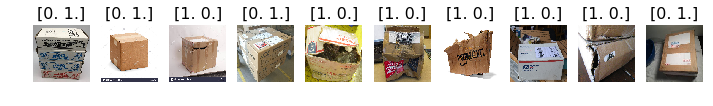

In [6]:
plots(imgs,titles=labels)

In [7]:


conv_base =InceptionV3(include_top=False, weights='imagenet', input_shape=(150,150,3))

In [8]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [9]:
from keras import models
from keras import layers

In [10]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 26,521,889
Trainable params: 26,487,457
Non-trainable params: 34,432
_________________________________________________________________


In [12]:
#Freeze the convolutional base first.
print('This is the number of trainable weights before freezing the conv base:' ,len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:' ,len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 192
This is the number of trainable weights after freezing the conv base: 4


In [13]:
#Now we prepare to run the images througn the neural network
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

#Training image augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        rotation_range = 50,
        width_shift_range = .2,
        height_shift_range= .2,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

#Making sure we have the right dimension size
training_generator = train_datagen.flow_from_directory(
        '/home/usojourn/Desktop/stanford_cs230/Project/parcels/training_set',
        target_size=(150,150),
        batch_size=10,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        '/home/usojourn/Desktop/stanford_cs230/Project/parcels/test_set',
        target_size=(150,150),
        batch_size=10,
        class_mode='binary')



validation_generator = valid_datagen.flow_from_directory(
        '/home/usojourn/Desktop/stanford_cs230/Project/parcels/validation_set',
        target_size=(150,150),
        batch_size=10,
        class_mode='binary')

Found 1929 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


In [14]:
# Compile the model
from keras import optimizers
model.compile(loss='binary_crossentropy',optimizer= optimizers.RMSprop(lr=.0001),metrics=['acc'])

In [15]:
# Fit the generator to the model
history = model.fit_generator(
        training_generator,
        steps_per_epoch=193,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=200, verbose=1)

Epoch 1/30
 23/193 [==>...........................] - ETA: 48s - loss: 1.0266 - acc: 0.5502

/home/usojourn/anaconda3/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


193/193 [==============================] - 54s 280ms/step - loss: 0.7094 - acc: 0.6417 - val_loss: 1.3329 - val_acc: 0.5729
Epoch 2/30
193/193 [==============================] - 48s 248ms/step - loss: 0.6064 - acc: 0.6977 - val_loss: 0.5144 - val_acc: 0.7638
Epoch 3/30
193/193 [==============================] - 49s 252ms/step - loss: 0.5829 - acc: 0.7056 - val_loss: 1.3746 - val_acc: 0.6884
Epoch 4/30
193/193 [==============================] - 49s 252ms/step - loss: 0.5616 - acc: 0.7222 - val_loss: 1.6814 - val_acc: 0.6633
Epoch 5/30
193/193 [==============================] - 48s 250ms/step - loss: 0.5642 - acc: 0.7401 - val_loss: 1.9594 - val_acc: 0.6131
Epoch 6/30
193/193 [==============================] - 49s 252ms/step - loss: 0.5371 - acc: 0.7428 - val_loss: 1.4008 - val_acc: 0.7186
Epoch 7/30
193/193 [==============================] - 48s 247ms/step - loss: 0.5234 - acc: 0.7645 - val_loss: 4.0521 - val_acc: 0.5226
Epoch 8/30
193/193 [==============================] - 49s 252ms/st

In [16]:
model.save('inception_aug_lr0001.h5')

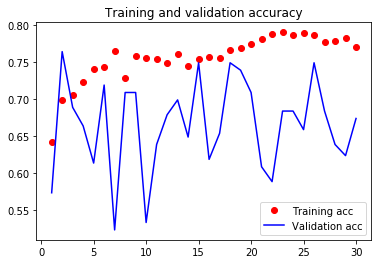

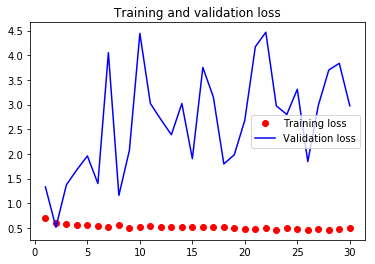

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo',color='red', label='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')

plt.legend()

plt.figure()


plt.plot(epochs, loss, 'bo',color='red', label='Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
test_images, test_labels = next(test_batches)

In [19]:
test_labels = test_labels[:,0]
test_labels

array([1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
       1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0.], dtype=float32)

In [20]:
predict = model.predict_generator(test_batches,steps=1,verbose=0)
predict

array([[1.0000000e+00],
       [9.9999988e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.5541959e-02],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.000000

In [21]:
n = 0

for i in predict:
    if (predict[n] > 0.5):
        predict[n] = 1
    else:
        predict[n] = 0
    n += 1

In [22]:
cm = confusion_matrix(test_labels,np.ceil(predict))

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    #This function prints and plots the confusion matrix.
    #Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

Confusion matrix, without normalization
[[ 2 98]
 [ 1 99]]


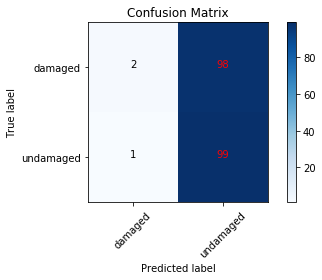

In [24]:
cm_plot_labels = ['damaged', 'undamaged']
plot_confusion_matrix(cm,cm_plot_labels, title='Confusion Matrix')

In [ ]:
K.clear_session()